# Описание проекта

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить закономерности, определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Описание данных

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

Прочтем файл и выведем первые 5 строчек датасета

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Выведем общую информацию о датасете

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Посмотрим на количество пропусков по каждому столбцу

In [4]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

**Вывод:** пропуски присутствуют в столбцах:
- Name
- Year_of_Release
- Genre 
- Critic_Score
- User_Score
- Rating

## Предобработка данных

Приведем названия столбцов к нижнему регистру

In [5]:
data.columns = data.columns.str.lower()

### Обработка пропущенных значений

Как мне кажется, пропуски имеют две причины:
1) пропуски имеют технологический характер, то есть банально что-то могло не записаться в таблицу

2) пропуски появились вследствие отсутствия некоторых данных

Начнем с колонки **year_of_release**. В датасете присутствуют игры по типу "fifa 2018", "nhl 2019" и тому подобное. Собственно, это и поможет нам заполнить некоторые пропуске в столбце с годом релиза. Чтобы избежать сюрпризов в названиях игр (например,  cyberpunk 2077, battlefield 2042, metro 2033 и тд),  введем ограничение во внутреннем цикле на год релиза.

Левым крайним значением будет год выпуска самой "старой" игры датасета

In [6]:
data['year_of_release'].min()

1980.0

Теперь можем заполнять пропуски year_of_release

In [7]:
for game in data[data['year_of_release'].isna()==True]['name']:
    for year in range(1980, 2022):
        if str(year) in game:
            data.loc[data.loc[:, 'name']==game,
                     'year_of_release'] = data.loc[data.loc[:, 'name']==game]['year_of_release'].fillna(year)
            

Столбец **rating**

Пропуски данного столбца можно заменить явными обозначениями "undefined"

In [8]:
data['rating'] = data['rating'].fillna('undefined')

Что касается остальных пропусков:
- name и genre - заполнять пропуски в названиях игр (и в соответствующих им жанрах) можно только тогда, когда мы точно знаем название игры и ее жанр. Это возможно только при обращении к сторонним иточникам информации
- critic_score и user_score - оценки критиков и пользователей. Заполнение пропусков синтетическими значениями в подобных данных может только навредить дальнейшим исследованиям, исказив исходное распределение. Pandas умеет работать с пропусками, поэтому иногда бывает так, что лучше всего просто забить на пропуск

### Обработка дубликатов

Для начала посчитаем количество явных дубликатов

In [9]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют

Теперь насчет неявных дубликатов. Повторы во всех столбцах - это нормальное явление, ведь не одна игра может быть выпущена в один и тот же год, или иметь одинаковую возрастную категорию и тд. Но есть еще столбец с названием игр. Посмотрим, сколько дубликатов в столбце name

In [10]:
data['name'].duplicated().sum()

5155

Но прежде, чем удалять эти повторы, посмотрим на эти данные в целом

In [11]:
data[data['name'].duplicated()==True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M
35,Call of Duty: Black Ops II,X360,2012.0,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M
37,Call of Duty: Modern Warfare 3,PS3,2011.0,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M
41,Call of Duty: Black Ops,PS3,2010.0,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M
...,...,...,...,...,...,...,...,...,...,...,...
16706,Men in Black II: Alien Escape,GC,2003.0,Shooter,0.01,0.00,0.00,0.00,NaN,tbd,T
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.00,0.00,0.00,0.00,NaN,NaN,undefined
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,undefined
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,undefined


Есть предположение, что повторы в названиях игр - это просто одни и те же игры на разных платформах. Проверим это на примере одной из игр

In [12]:
data[data['name']=='Grand Theft Auto V']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M
165,Grand Theft Auto V,XOne,2014.0,Action,2.81,2.19,0.00,0.47,97.0,7.9,M
1730,Grand Theft Auto V,PC,2015.0,Action,0.39,0.69,0.00,0.09,96.0,7.9,M


Действительно, вышесказанное предположение подтвердилось. Следовательно, удалять такие "дубликаты" не стоит. Но, возможно, что есть дубликаты и по играм, и по платформам одновременно. Проверим это.

In [13]:
data[data[['name', 'platform']].duplicated()==True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.0,0.48,0.00,0.00,43.0,4.1,E10+
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.00,NaN,NaN,undefined
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E


И правда, такие дубликаты присутствуют. Но прежде, чем от них избавляться, изучим их более детально. 

**Need for Speed: Most Wanted (X360)**

In [14]:
data[(data['name']=='Need for Speed: Most Wanted')&(data['platform']=='X360')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T


**Sonic the Hedgehog**

In [15]:
data[(data['name']=='Sonic the Hedgehog')&(data['platform']=='PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+


**Need for Speed: Most Wanted (PC)**

In [16]:
data[(data['name']=='Need for Speed: Most Wanted')&(data['platform']=='PC')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.0,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.00,0.06,0.0,0.02,82.0,8.5,T


**Madden NFL 13**

In [17]:
data[(data['name']=='Madden NFL 13')&(data['platform']=='PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Что касается NFS и Sonic, то это просто разные части одной и той же игры (NFS действительно выходил в 2005, а вторая часть как раз в 2012). Остается только 2 неявных дубликата - это неизвестный NaN и Madden NFL 13. И их настолько ничтожно мало, что они врядли как-то помешают исследованию

### Приведение данных к нужному типу

Посмотрим, какие типы данных соответствуют каждому столбцу

In [18]:
data.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

#### Столбец year_of_release

Значения столбца - год выпуска. Следовательно, тип данных в столбце должен быть int

In [19]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

#### Столбец user_score

Тип столбца - object. Чтобы перевести его в float, необходимо воспользовтаься методом to_numeric, имеющий параметр errors для обработки ошибок. Данный параметр может принимать три значения: raise, coerce, ignore. Чтобы понять, какой корректнее всего применить, посмотрим на уникальные значения столбца

In [20]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Как можно увидеть, здесь присутствует некий tbd. Эта аббревиатура обозначает to be determined (подлежит уточнению). По сути, это обычный пропуск, поэтому параметр errors можно задать как coerce 

In [21]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

### Подсчет суммарных продаж во всех регионах

Создадим столбец, сожержащий суммарные продажи по всем регионам

In [22]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

## Исследовательский анализ данных

### Количество игр по годам выпуска

Построим распределение количества релизов по годам

Text(0.5, 1.0, 'Распределение количества релизов по годам')

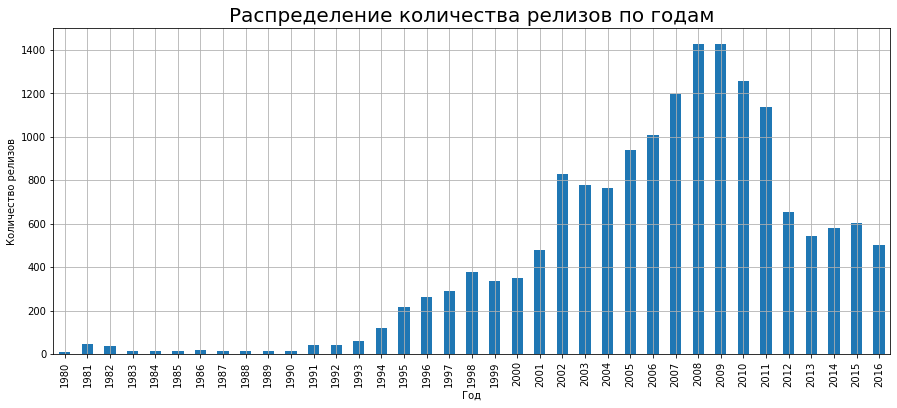

In [23]:
data.pivot_table(index='year_of_release', values='name',
                                        aggfunc='count').plot(y='name', legend=False,
                                        kind='bar', figsize=(15,6), grid=True)
plt.ylabel('Количество релизов')
plt.xlabel('Год')
plt.title('Распределение количества релизов по годам', fontsize=20)

По гистограмме видно, что резкий скачок по количеству игр, выпущенных в год, произошел в 2002 году. Пик пришелся на 2008-2009. После этого начался спад.

При прогнозировании на будущее, необходимо определить актуальный период, а не брать данные за все время.


### Изменение продаж в зависимости от платформы

Построим распределение продаж по платформам

Text(0.5, 1.0, 'Распределение суммарных продаж по платформам')

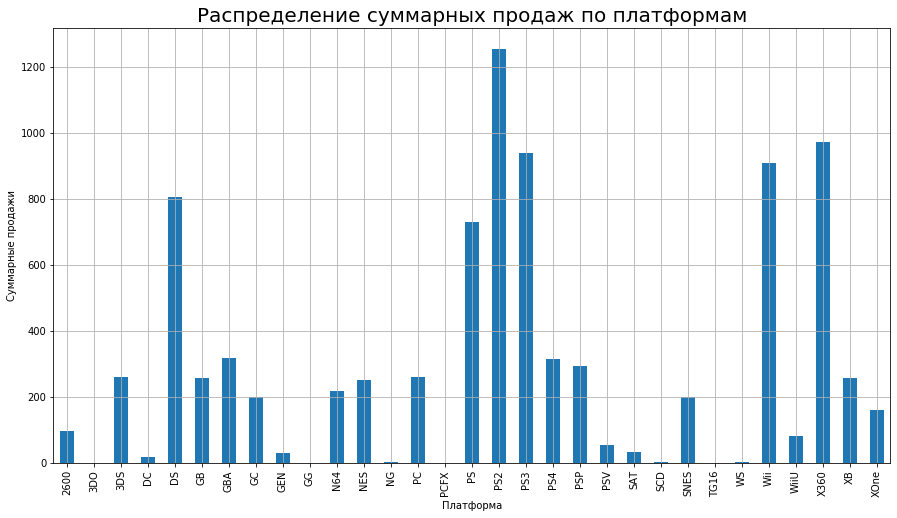

In [24]:
data.pivot_table(index='platform', values='total_sales',
                 aggfunc='sum').plot(y='total_sales', kind='bar', legend=False, figsize=(15,8), grid=True)
plt.ylabel('Суммарные продажи')
plt.xlabel('Платформа')
plt.title('Распределение суммарных продаж по платформам', fontsize=20)

Платформы с наибольшими суммарными продажами:
- DS
- PS
- PS2
- PS3 
- Wii
- X360

Построим распределение количества игр на платформах с наибольшими суммарными продажами по годам

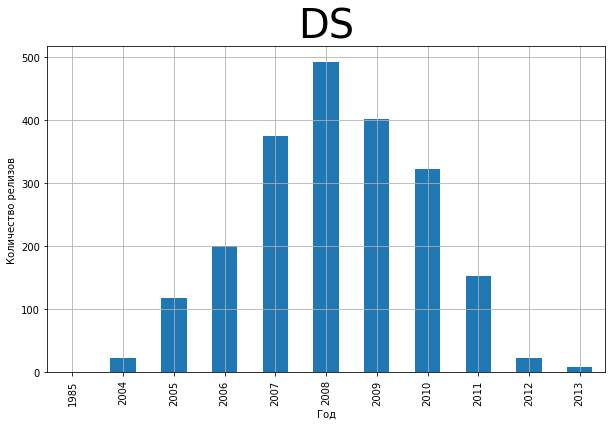

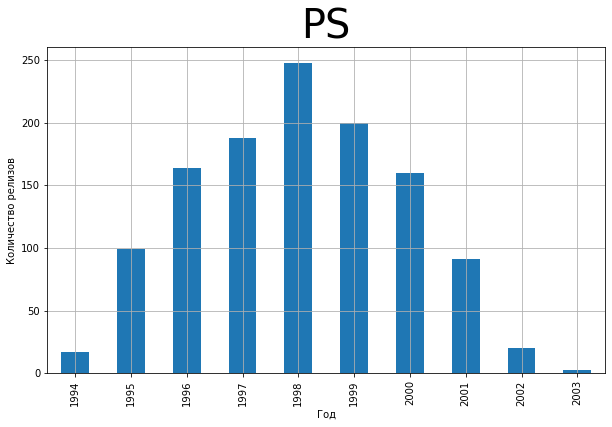

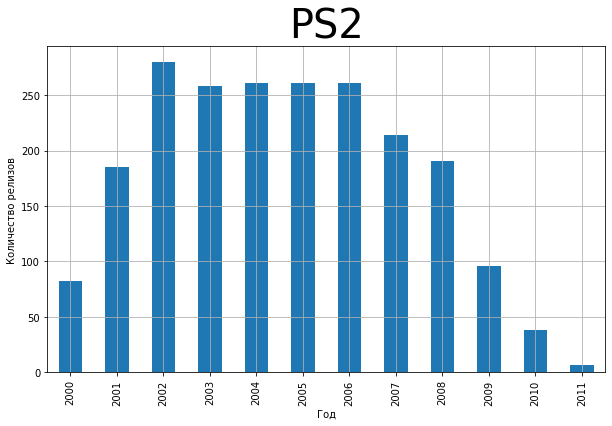

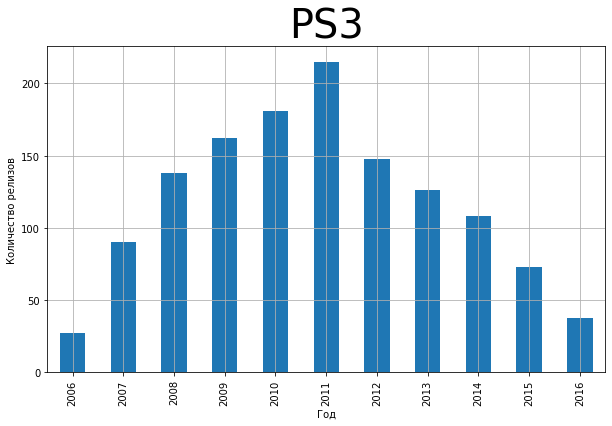

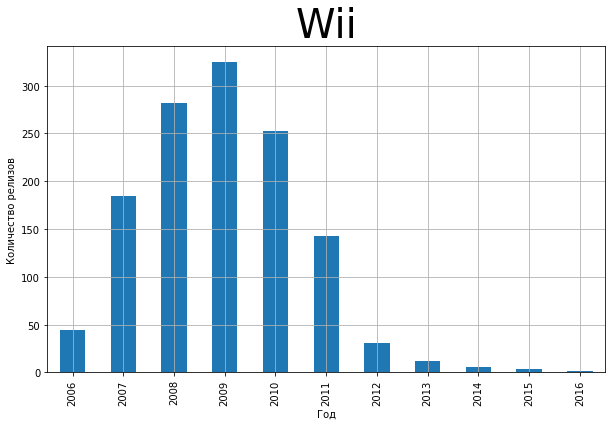

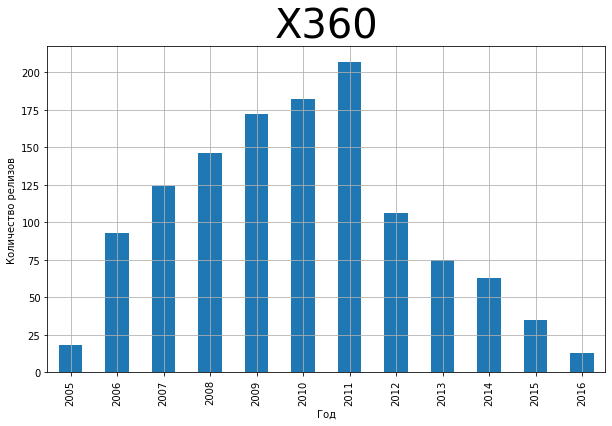

In [25]:
popular_platforms = ['DS', 'PS', 'PS2', 'PS3', 'Wii', 'X360']
for platform in popular_platforms:
    data[data['platform']==platform].pivot_table(index='year_of_release', values='total_sales',
                                         aggfunc='count').plot(y='total_sales', legend=False,
                                                             kind='bar', figsize=(10,6), grid=True)
    plt.title(platform, fontsize=40)
    plt.ylabel('Количество релизов')
    plt.xlabel('Год')
    plt.show()
    print('\n')

Из построенных распределений можно сделать следующие выводы касательно периодов жизни конкретных платформ:
- DS - с 2005 по 2011 год
- PS - с 1994 по 2001 год
- PS2 - с 2000 по 2009 год
- PS3 - с 2006 по 2014 год
- Wii - с 2006 по 2011 год
- X360 - с 2005 по 2015 год

Так же можно сказать, что характерный срок появления новых и исчезчезновения старых платформ - примерно 8 лет

### Выбор актуального периода

Посмотрим на распределение количества релизов по годам еще раз

Text(0.5, 1.0, 'Распределение количества релизов по годам')

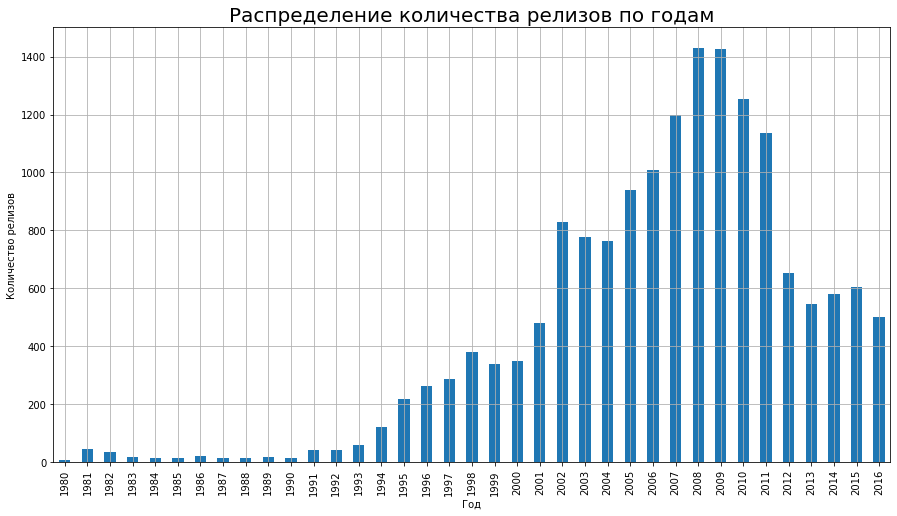

In [26]:
data.pivot_table(index='year_of_release', values='name',
                                        aggfunc='count').plot(y='name', legend=False,
                                        kind='bar', figsize=(15,8), grid=True)
plt.ylabel('Количество релизов')
plt.xlabel('Год')
plt.title('Распределение количества релизов по годам', fontsize=20)

Необходимо выбрать актуальный период для прогнозирования количества релизов на 2017 год. На мой взгляд, **актуальный период приходится на 2010-2016**, так как в эти года пошла тенденция на спад количества релизов (как итог, и игровой индутсрии в целом). Возможно, это связано с внедрением смартфонов в нашу жизнь и стремительному развитию социальных сетей. 

Отбросим данные до 2010 года для дальнейшей работы

In [27]:
new_data = data.query('year_of_release >= 2010')

### Топ потенциально прибыльных платформ

Посмотрим, как менялись суммарные продажи по годам для каждой из платформ

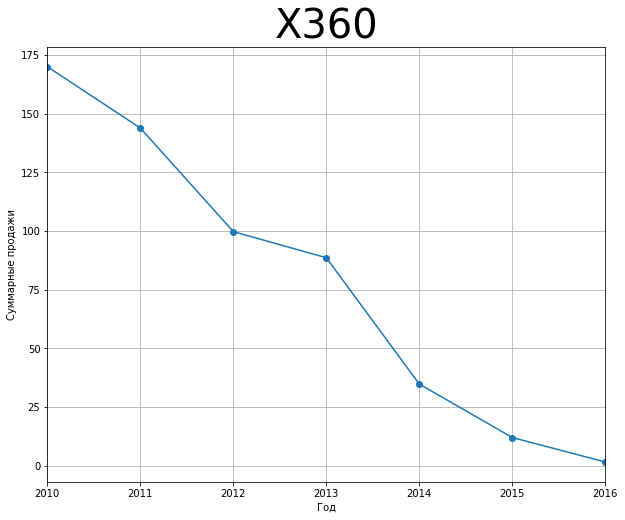

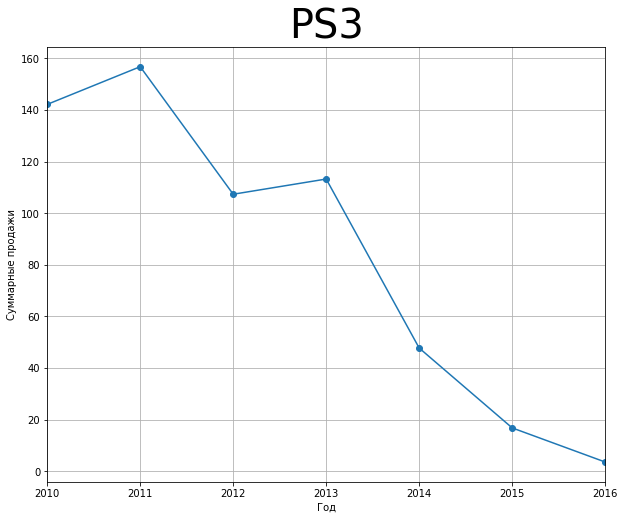

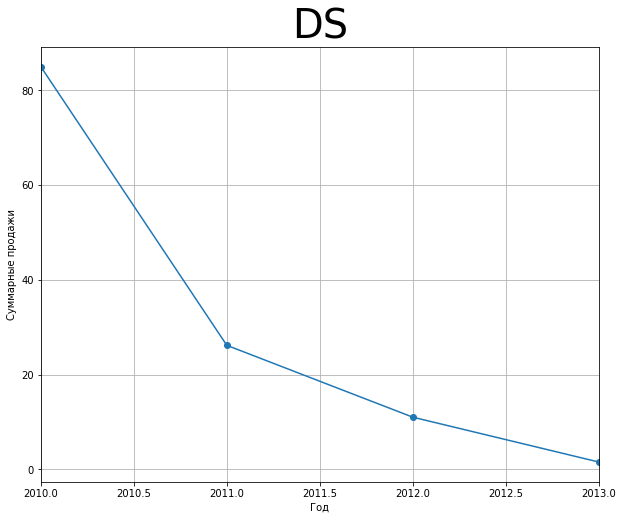

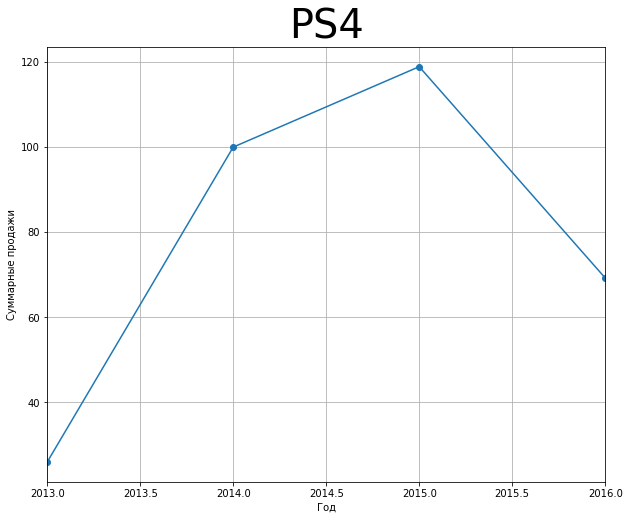

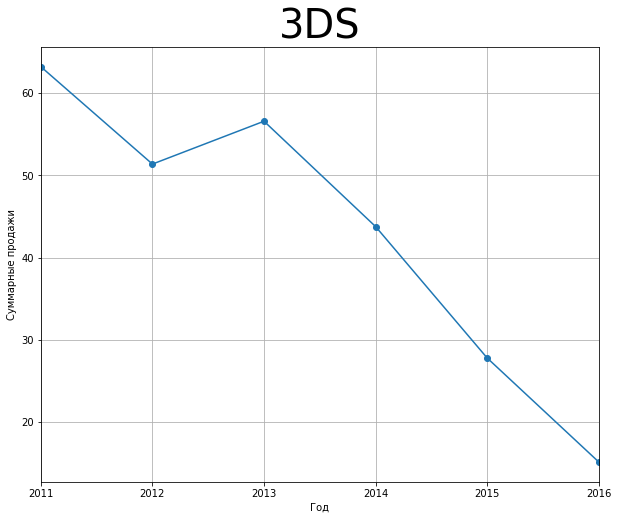

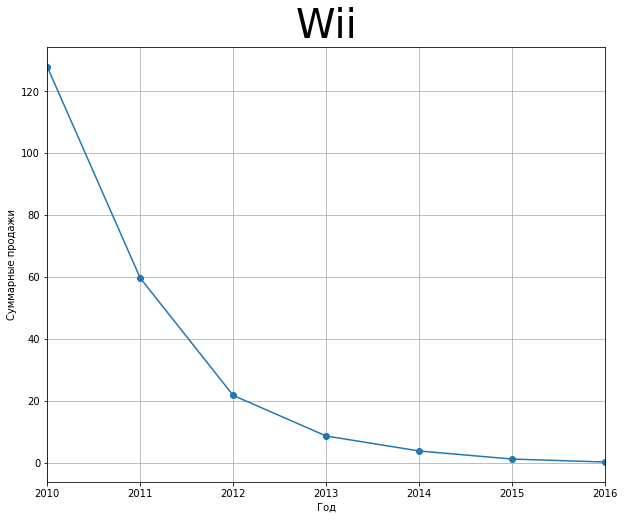

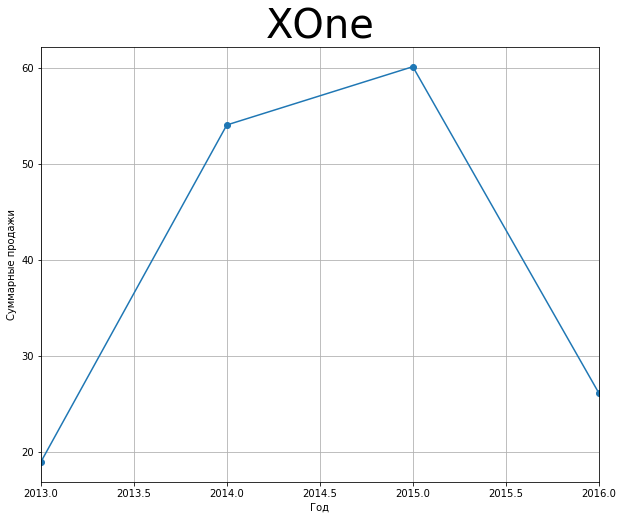

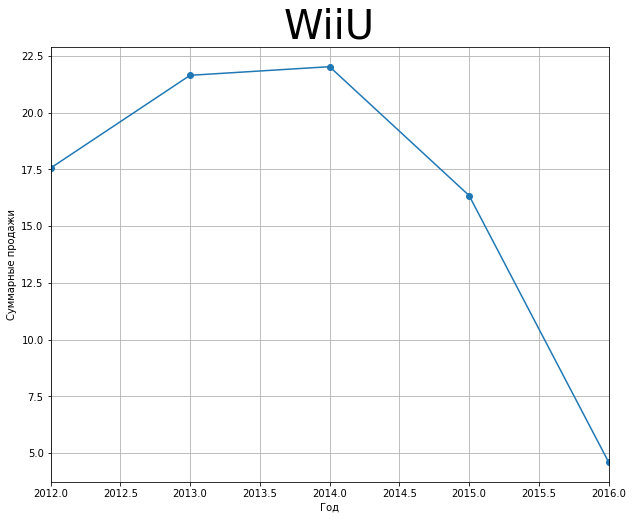

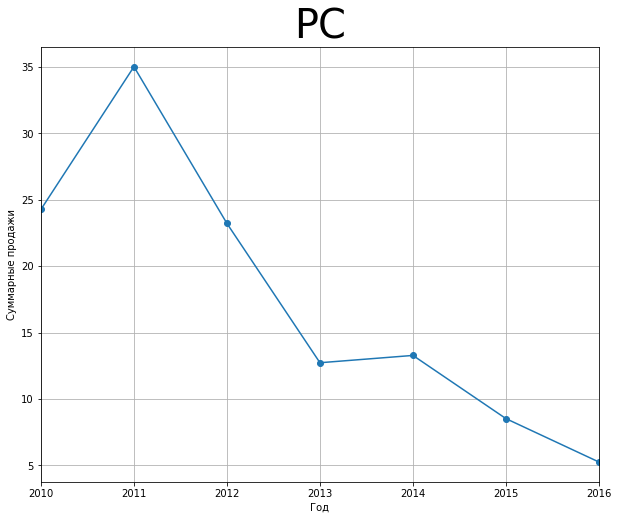

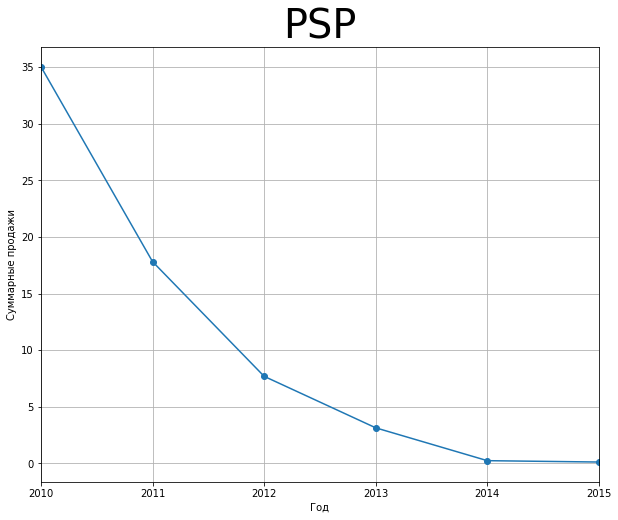

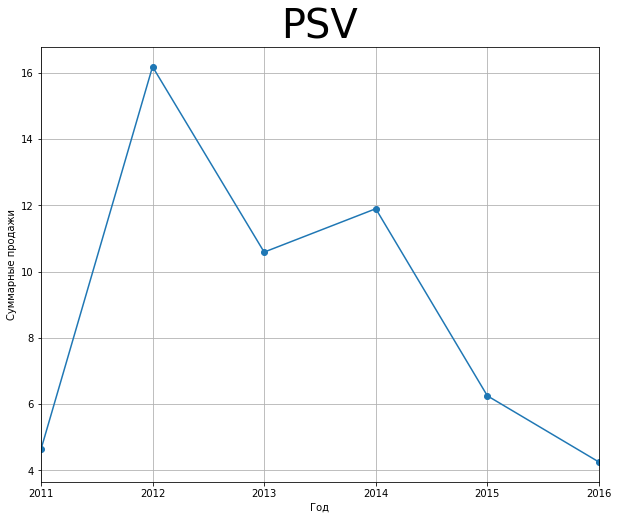

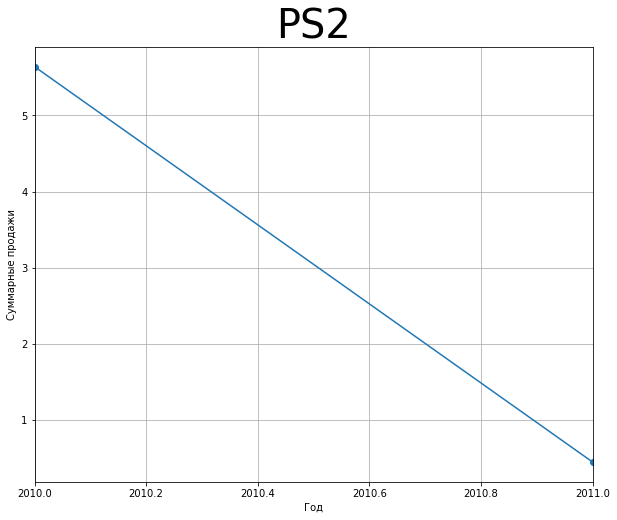

In [28]:
for platform in new_data['platform'].unique():
    new_data.query('platform==@platform').pivot_table(index='year_of_release',
                                    values='total_sales', aggfunc='sum').plot(y='total_sales',
                                    grid=True, figsize=(10,8), style='o-', legend=False)
    plt.title(platform, fontsize=40)
    plt.xlabel('Год')
    plt.ylabel('Суммарные продажи')

Из полученных графиков можно сделать вывод, что на конец 2016 топ-2 потенциально прибыльных платформ -  это  PS4 и XOne. Причем, исходя из данных, количество продаж игр, выпущенных на каждую из этих платформ, снижается. Таким образом, можно сказать, что весь рынок игр падает.

### Boxplot 

Boxplot по глобальным продажам игр в разбивке по платформам

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 2)

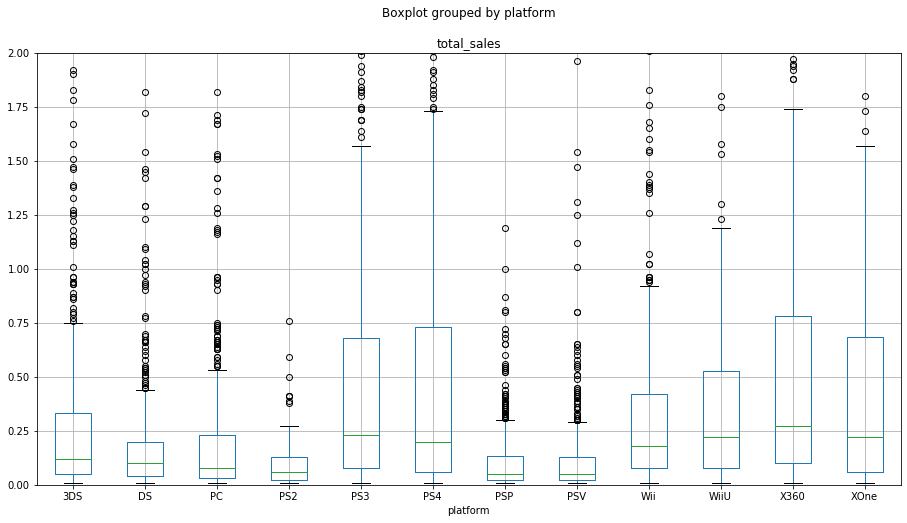

In [29]:
new_data.boxplot('total_sales', by='platform', figsize=(15,8))
plt.ylim(0, 2)

Платформы с наибольшими медианными суммарными продажами:
- PS3
- X360
- PS4
- XOne
- WiiU

Платформы с наибольшим интерквантильным размахом:
- PS3
- X360
- PS4
- XOne


### Взаимосвязь отзывов с продажами

Необходимо сформировать список популярных платформ с учетом того, что мы исключили всю информацию до 2010 года (**актуальная** new_data)

Text(0.5, 1.0, 'Распределение суммарных продаж по платформам')

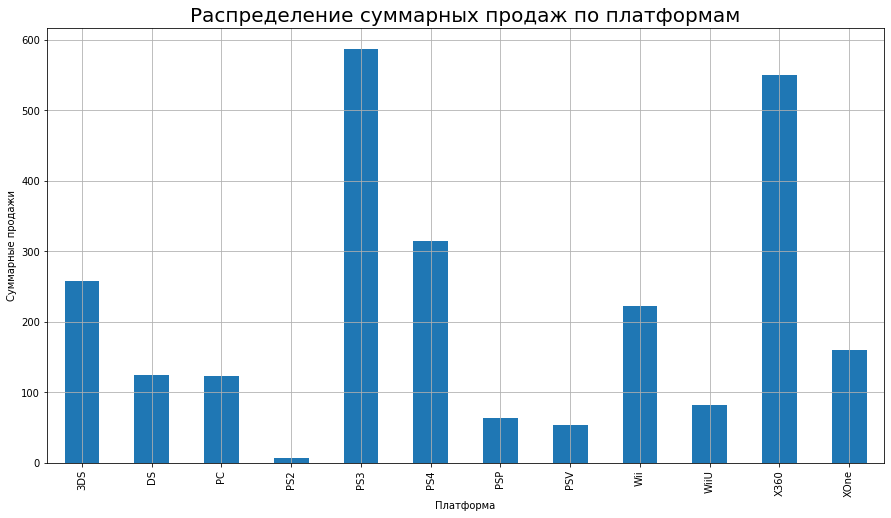

In [30]:
new_data.pivot_table(index='platform', values='total_sales',
                 aggfunc='sum').plot(y='total_sales', kind='bar', legend=False, figsize=(15,8), grid=True)
plt.ylabel('Суммарные продажи')
plt.xlabel('Платформа')
plt.title('Распределение суммарных продаж по платформам', fontsize=20)

Список наиболее популярных платформ(с учетом формирования актуальной информации new_data) имеет вид:
- PS3
- X360
- PS4
- 3DS
- Wii

#### Отзывы критиков

Построим зависимости суммарных продаж от отзывов критиков для каждой из популярных платформ. Также, посчитаем коэффициент корреляции.

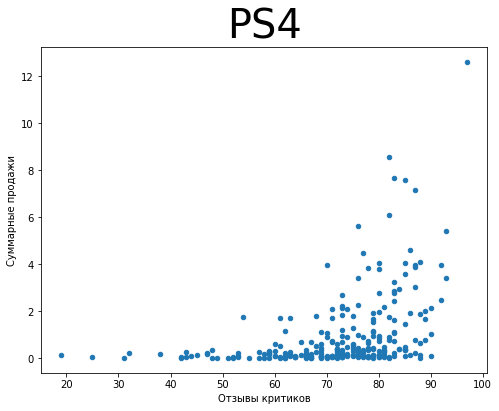

Коэффициент корреляции 0.406567902061781




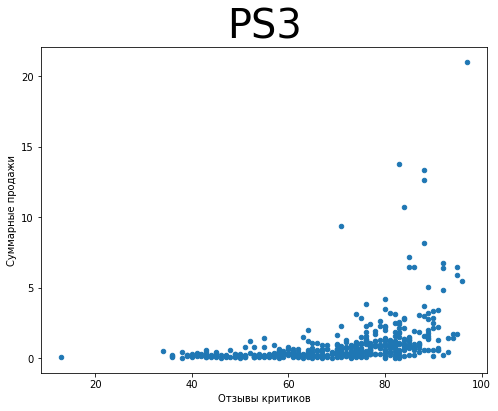

Коэффициент корреляции 0.40059409352022496




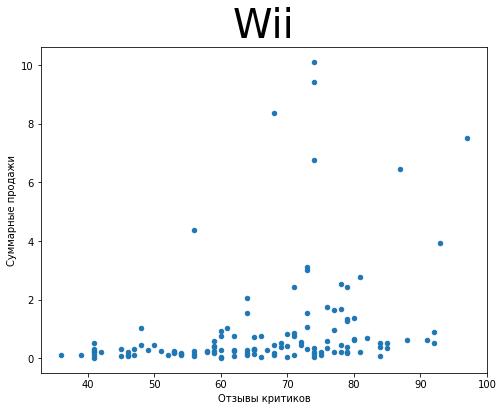

Коэффициент корреляции 0.31058771048209965




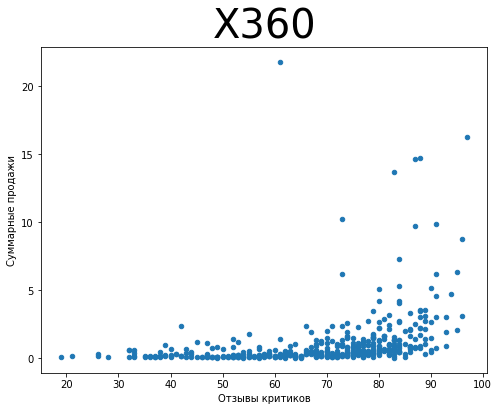

Коэффициент корреляции 0.3407633525432405




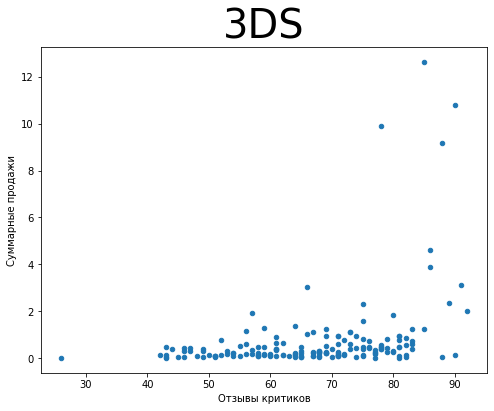

Коэффициент корреляции 0.34873973059848346




In [31]:
popular_platforms = ['PS4', 'PS3', 'Wii', 'X360', '3DS']
for platform in popular_platforms:
    new_data.query('platform==@platform').plot(x='critic_score',y='total_sales',
                                            kind='scatter', figsize=(8,6))
    plt.title(platform, fontsize=40)
    plt.xlabel('Отзывы критиков')
    plt.ylabel('Суммарные продажи')
    plt.show()
    print('Коэффициент корреляции', new_data.query('platform==@platform')['total_sales'].corr(new_data['critic_score']))
    print('\n')
    
    


У всех популярных платформ наблюдается слабая положительная корреляция между отзывами критиков и суммарными продажами.

#### Отзывы пользователей

Построим зависимости суммарных продаж от отзывов пользователей для каждой из популярных платформ. Также, посчитаем коэффициент корреляции.

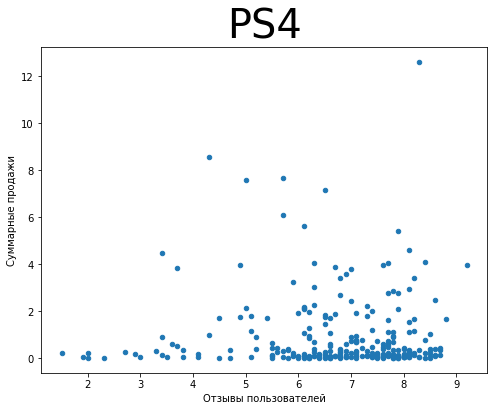

Коэффициент корреляции: -0.031957110204556424




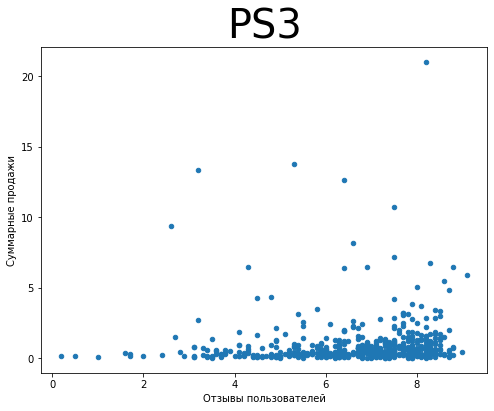

Коэффициент корреляции: 0.06509241630476506




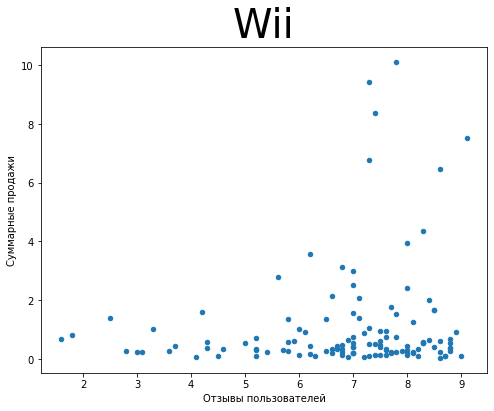

Коэффициент корреляции: 0.14715977707531702




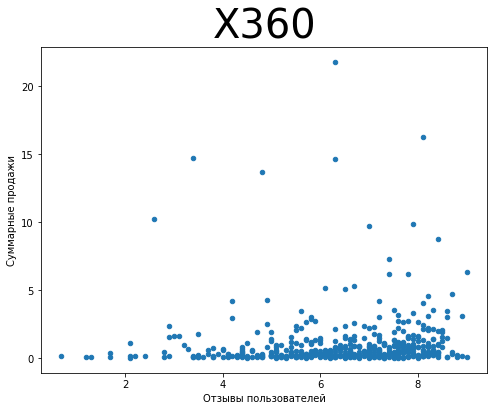

Коэффициент корреляции: 0.06526407363097732




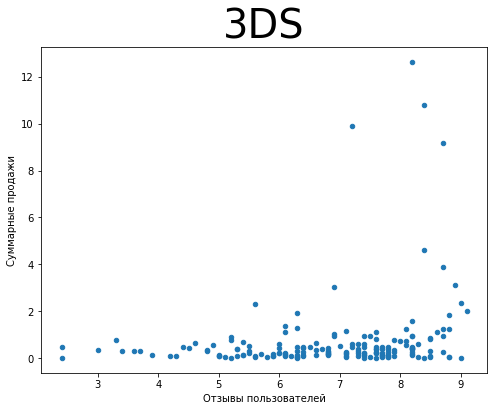

Коэффициент корреляции: 0.22207843643390884




In [32]:
for platform in popular_platforms:
    new_data.query('platform==@platform').plot(x='user_score',y='total_sales',
                                            kind='scatter', figsize=(8,6))
    plt.title(platform, fontsize=40)
    plt.xlabel('Отзывы пользователей')
    plt.ylabel('Суммарные продажи')
    plt.show()
    print('Коэффициент корреляции:', new_data.query('platform==@platform')['total_sales'].corr(new_data['user_score']))
    print('\n')
    
    


У 3DS наблюдается очень слабая положительная корреляция между отзывами пользователей и суммарными продажами. Для остальных платформ эта корреляция практически нулевая, что говорит о полном отсутствии какой-либо зависимости между отзывами пользователей и суммарными продажами. Хотя стоит отметить, что PS4 - единственная платформа, у которой наблюдается отрицательная корреляция. Тем не менее, она практически нулевая.

### Распределение суммарных продаж по жанрам

Построим распределение суммарных продаж по жанрам

Text(0.5, 1.0, 'Распределение суммарных продаж по жанрам')

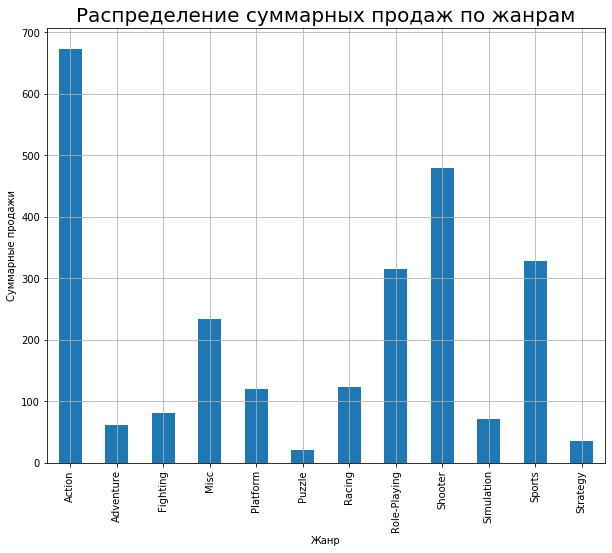

In [33]:
new_data.pivot_table(index='genre', values='total_sales',
                     aggfunc='sum').plot(y='total_sales', kind='bar', figsize=(10,8),
                                         grid=True, legend=False)
plt.ylabel('Суммарные продажи')
plt.xlabel('Жанр')
plt.title('Распределение суммарных продаж по жанрам', fontsize=20)

Самыми прибыльными жанрами являются:
- Action
- Shooter
- Sports
- Role-Playing
- Misc

Жанры с низкими продажами:
- Adventure
- Strategy
- Puzzle




Посмотрим на количество игр в каждом жанре

Text(0.5, 1.0, 'Распределение количества игр по жанрам')

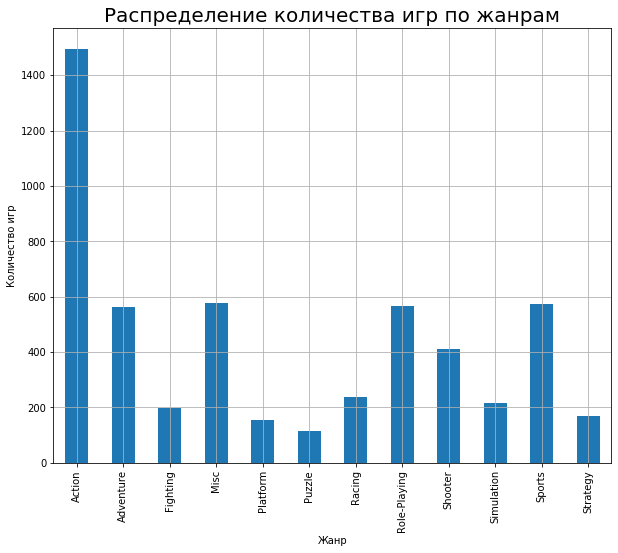

In [34]:
new_data.pivot_table(index='genre', values='total_sales',
                     aggfunc='count').plot(y='total_sales', kind='bar', figsize=(10,8),
                                         grid=True, legend=False)
plt.ylabel('Количество игр')
plt.xlabel('Жанр')
plt.title('Распределение количества игр по жанрам', fontsize=20)

Так как количество игр в жанрах сильно различается (с отрывом лидирует Action; Adventure, Misc, Role-Playing и Sports занимают среднюю нишу, остальные жестко просаживаются), то посчитаем медианные продажи по жанрам, чтобы понять, какой жанр обычно продается лучше

Text(0.5, 1.0, 'Распределение медианных продаж по жанрам')

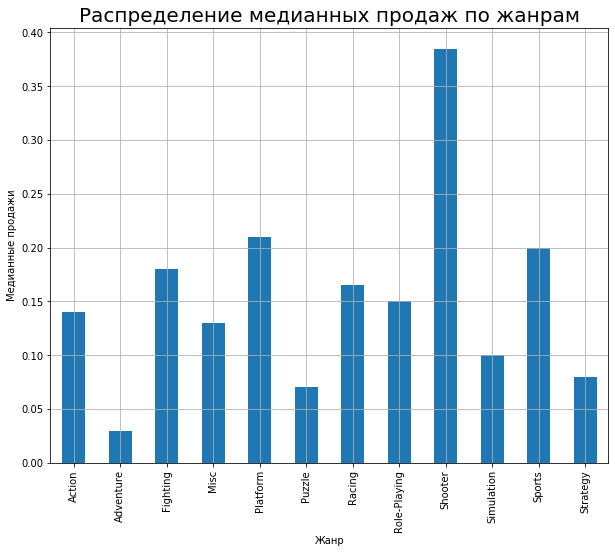

In [35]:
new_data.pivot_table(index='genre', values='total_sales',
                     aggfunc='median').plot(y='total_sales', kind='bar', figsize=(10,8),
                                         grid=True, legend=False)
plt.ylabel('Медианные продажи')
plt.xlabel('Жанр')
plt.title('Распределение медианных продаж по жанрам', fontsize=20)

Из распределения видно, что игры жанра Shooter продаются лучше всего

## Портрет пользователя каждого региона

### Северная Америка (NA)

# Топ-5 платформ

Построим распределение продаж в Северной Америке по платформам

Text(0, 0.5, 'Продажи в Северной Америке')

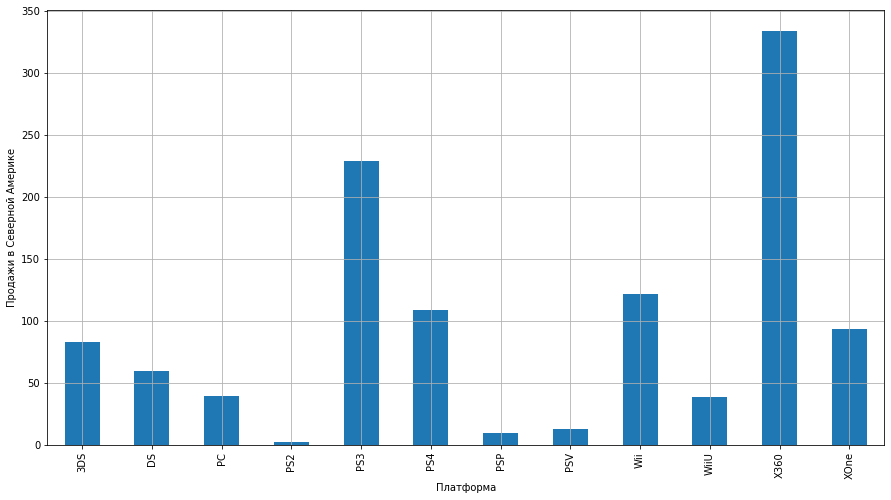

In [36]:
new_data.pivot_table(index='platform', values='na_sales',
                     aggfunc='sum').plot(y='na_sales', kind='bar',
                      grid=True, figsize=(15,8), legend=False)
plt.xlabel('Платформа')
plt.ylabel('Продажи в Северной Америке')

Выведем на экран **топ-5** популярных платформ в Северной Америке

In [37]:
new_data.pivot_table(index='platform', values='na_sales',
                     aggfunc='sum').sort_values(by='na_sales', ascending=False).head()

,na_sales
platform,
X360,334.18
PS3,229.25
Wii,121.20
PS4,108.74
XOne,93.12


# Топ-5 жанров

Построим распределение продаж в Северной Америке по жанрам

Text(0.5, 0, 'Жанр')

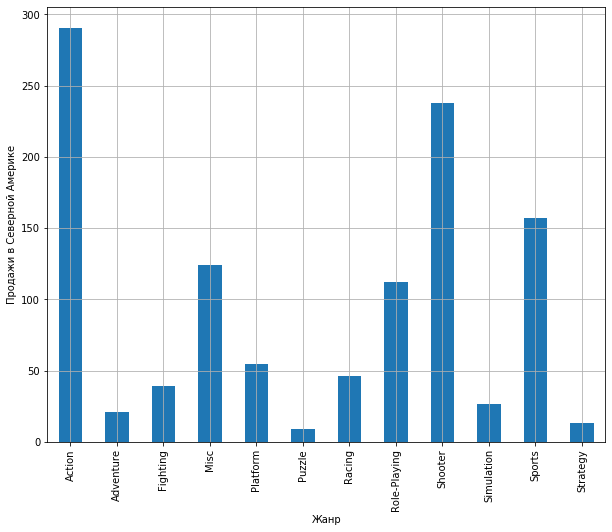

In [38]:
new_data.pivot_table(index='genre', values='na_sales',
                     aggfunc='sum').plot(y='na_sales', kind='bar', figsize=(10,8),
                                         grid=True, legend=False)
plt.ylabel('Продажи в Северной Америке')
plt.xlabel('Жанр')

Выведем на экран **топ-5** популярных жанров в Северной Америке

In [39]:
new_data.pivot_table(index='genre', values='na_sales',
                     aggfunc='sum').sort_values(by='na_sales', ascending=False).head()

,na_sales
genre,
Action,290.70
Shooter,237.47
Sports,156.81
Misc,123.80
Role-Playing,112.05


# Влияние рейтинга ESBR на продажи

Посмотрим, как влияет рейтинг ESRB на продажи в Северной Америке

Text(0.5, 0, 'Возрастной рейтинг')

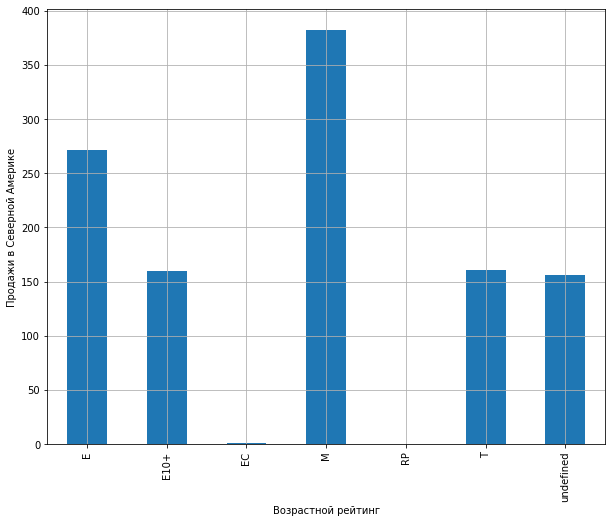

In [40]:
new_data.pivot_table(index='rating', values='na_sales',
                     aggfunc='sum').plot(y='na_sales', kind='bar', figsize=(10,8),
                                         grid=True, legend=False)
plt.ylabel('Продажи в Северной Америке')
plt.xlabel('Возрастной рейтинг')

Наибольшее количество продаж у игр с рейтингом M, далее идет E. Между рейтингами E10+, T и undefined продажи распределены примерно поровну. Что касается игр с рейтингом EC и RP, то они спросом не пользуются и их продажи практически нулевые.

### Европа (EU)

# Топ-5 платформ

Построим распределение продаж в Европе по платформам

Text(0, 0.5, 'Продажи в Европе')

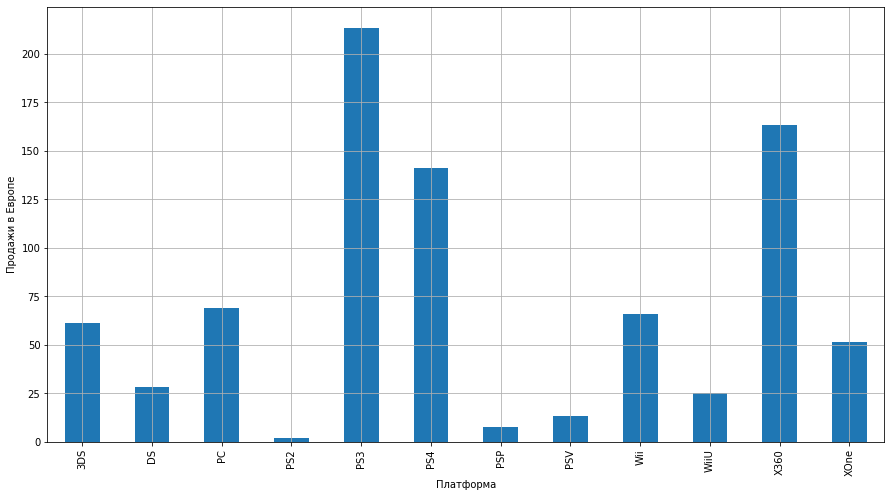

In [41]:
new_data.pivot_table(index='platform', values='eu_sales',
                     aggfunc='sum').plot(y='eu_sales', kind='bar',
                      grid=True, figsize=(15,8), legend=False)
plt.xlabel('Платформа')
plt.ylabel('Продажи в Европе')

Выведем на экран **топ-5** популярных платформ в Европе

In [42]:
new_data.pivot_table(index='platform', values='eu_sales',
                     aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()

,eu_sales
platform,
PS3,213.60
X360,163.45
PS4,141.09
PC,69.07
Wii,65.91


# Топ-5 жанров

Построим распределение продаж в Европе по жанрам

Text(0.5, 0, 'Жанр')

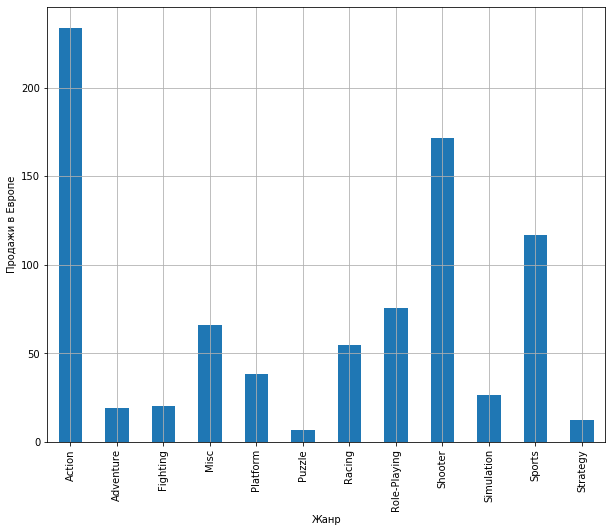

In [43]:
new_data.pivot_table(index='genre', values='eu_sales',
                     aggfunc='sum').plot(y='eu_sales', kind='bar', figsize=(10,8),
                                         grid=True, legend=False)
plt.ylabel('Продажи в Европе')
plt.xlabel('Жанр')

Выведем на экран **топ-5** популярных жанров в Европе

In [44]:
new_data.pivot_table(index='genre', values='eu_sales',
                     aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()

,eu_sales
genre,
Action,233.88
Shooter,171.45
Sports,116.84
Role-Playing,75.48
Misc,66.09


# Влияние рейтинга ESBR на продажи

Посмотрим, как влияет рейтинг ESRB на продажи в Европе

Text(0.5, 0, 'Возрастной рейтинг')

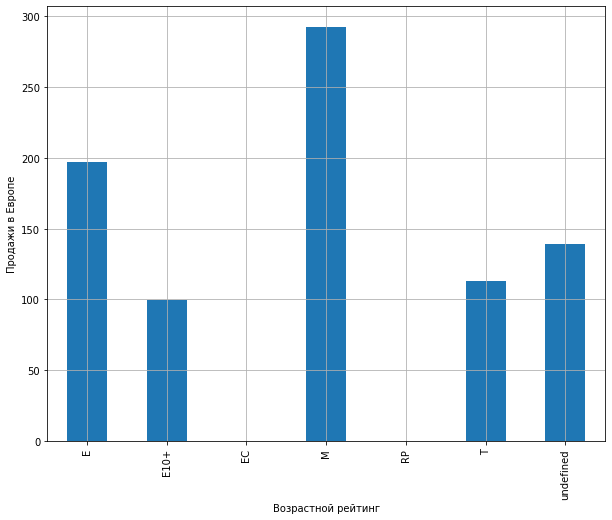

In [45]:
new_data.pivot_table(index='rating', values='eu_sales',
                     aggfunc='sum').plot(y='eu_sales', kind='bar', figsize=(10,8),
                                         grid=True, legend=False)
plt.ylabel('Продажи в Европе')
plt.xlabel('Возрастной рейтинг')

Наибольшее количество продаж у игр с рейтингом M и E. Примерно одинаковые продажи имею игры с рейтингами E10+, T и undefined. Что касается игр с рейтингом EC и RP, то они спросом не пользуются и их продажи практически нулевые.

### Япония (JP)

# Топ-5 платформ

Построим распределение продаж в Японии по платформам

Text(0, 0.5, 'Продажи в Японии')

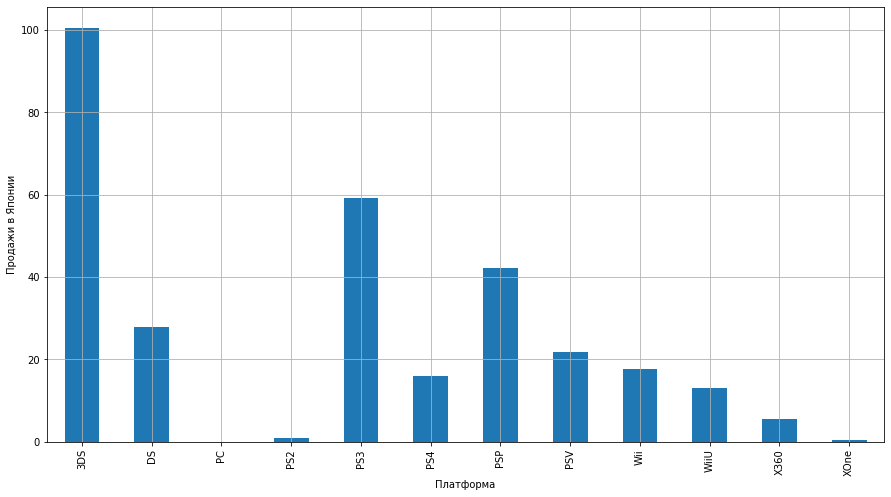

In [46]:
new_data.pivot_table(index='platform', values='jp_sales',
                     aggfunc='sum').plot(y='jp_sales', kind='bar',
                      grid=True, figsize=(15,8), legend=False)
plt.xlabel('Платформа')
plt.ylabel('Продажи в Японии')

Выведем на экран **топ-5** популярных платформ в Японии

In [47]:
new_data.pivot_table(index='platform', values='jp_sales',
                     aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()

,jp_sales
platform,
3DS,100.62
PS3,59.26
PSP,42.20
DS,27.90
PSV,21.84


# Топ-5 жанров

Построим распределение продаж в Японии по жанрам

Text(0.5, 0, 'Жанр')

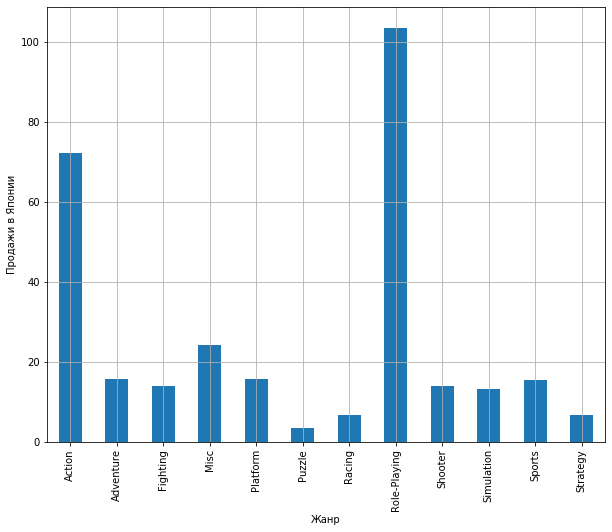

In [48]:
new_data.pivot_table(index='genre', values='jp_sales',
                     aggfunc='sum').plot(y='jp_sales', kind='bar', figsize=(10,8),
                                         grid=True, legend=False)
plt.ylabel('Продажи в Японии')
plt.xlabel('Жанр')

Выведем на экран **топ-5** популярных жанров в Японии

In [49]:
new_data.pivot_table(index='genre', values='jp_sales',
                     aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()

,jp_sales
genre,
Role-Playing,103.54
Action,72.20
Misc,24.29
Platform,15.81
Adventure,15.67


# Влияние рейтинга ESBR на продажи

Посмотрим, как влияет рейтинг ESRB на продажи в Японии

Text(0.5, 0, 'Возрастной рейтинг')

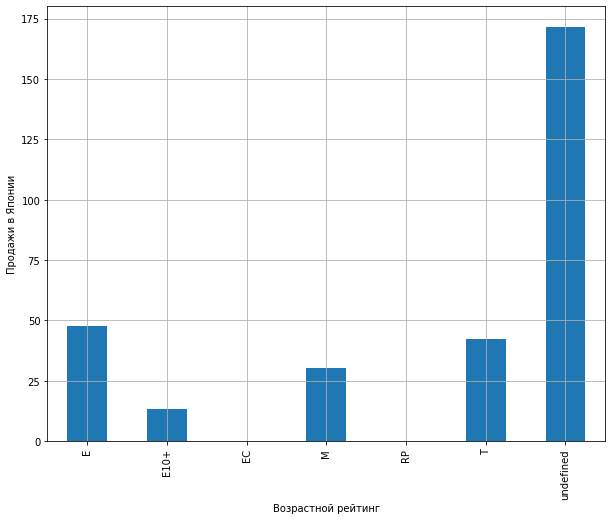

In [50]:
new_data.pivot_table(index='rating', values='jp_sales',
                     aggfunc='sum').plot(y='jp_sales', kind='bar', figsize=(10,8),
                                         grid=True, legend=False)
plt.ylabel('Продажи в Японии')
plt.xlabel('Возрастной рейтинг')

Лидирующую позицию занимают игры с неопределенным возрастным рейтингом undefined. Примерно одинаковые продажи имеют игры с рейтингами E, M, T и E10+. Что касается игр с рейтингом EC и RP, то они спросом не пользуются и их продажи практически нулевые.

### Вывод

У каждого региона свои особенности. В Северной Америке любимая платформа X360, в Европе - PS3, а в Японии пользователи выбирают 3DS. Жанровые предпочтения тоже отличаются: в Северной Америке и Европе популярны Action и Shooter, а в Японии любимый жанр - это Role-Playing. Возрастной рейтинг также по разному влияет на продажи в определенном регионе. Так, в Северной Америке и Европе наиболее продаваемыми являются игры с возрастными рейтингами M и E. В Японии лучше всего продаются игры с неопределенным жанром undefined.

## Проверка гипотез

### Первая гипотеза

# "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

Чтобы это проверить, необходимо сформулировать нулевую (H0) и альтернативную гипотезу (H1):
- Нулевая гипотеза (H0) - средние пользовательские рейтинги платформ Xbox One и PC **равны**
- Альтернативная гипотеза (H1) - средние пользовательские рейтинги платформ Xbox One и PC **различаются**

Для проверки гипотез будем использовать двусторонний t-тест для двух генеральных совокупностей. Зададим пороговое значение aplha = 0.05

In [51]:
alpha = 0.05
result_1 = st.ttest_ind(new_data[new_data['platform']=='PC']['user_score'],
                        new_data[new_data['platform']=='XOne']['user_score'], nan_policy='omit')
result_1.pvalue

0.9880737458826817

Полученное p-value больше порогового значения. Следовательно, нулевая гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC верна. 

Значит, средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**

### Вторая гипотеза

# "Средние пользовательские рейтинги жанров Action и Sports разные"

Чтобы это проверить, необходимо сформулировать нулевую (H0) и альтернативную гипотезу (H1):
- Нулевая гипотеза (H0) - средние пользовательские рейтинги жанров Action и Sports **равны**
- Альтернативная гипотеза (H1) - средние пользовательские рейтинги жанров Action и Sports **различаются**

Для проверки гипотез будем использовать двусторонний t-тест для двух генеральных совокупностей. Зададим пороговое значение aplha = 0.05

In [52]:
result_2 = st.ttest_ind(new_data[new_data['genre']=='Action']['user_score'],
                       new_data[new_data['genre']=='Sports']['user_score'], nan_policy='omit')
result_2.pvalue

6.455134947955995e-19

Полученное p-value меньше порогового значения. Следовательно, отвергаем нулевую гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports. 

Значит, средние пользовательские рейтинги жанров Action и Sports **разные**

## Общий вывод

В проекте был проведен анализ игровой индустрии. Мы выяснили, что:
- пик развития игровой индустрии пришелся на середину-конец нулевых
- потенциально прибыльными платформами являются PS4 и XOne (что вполне логично, учитывая, что обе платформы вышли в продажу в 2013 году)
- суммарные продажи игр слабо зависят от оценки критиков и практически не зависят от оценки пользователей
- Япония выделяется среди остальных регионов своими специфическими игровыми предпочтениями
- средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- средние пользовательские рейтинги жанров Action и Sports разные